## Importing Required Libraries

In [2]:
import nltk
import pandas as pd
import numpy as np
import tensorflow as tf
from nltk import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
spam_data = pd.read_csv('spam.csv', encoding='latin-1', usecols=[0, 1], names=['label', 'message'], skiprows=1)

In [4]:
print(spam_data.head())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [5]:
# converting label to 0 for ham and 1 for spam
label_encoder = LabelEncoder()
spam_data['label'] = label_encoder.fit_transform(spam_data['label'])

In [6]:
print(spam_data.head())

   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


## Data Processing

### Data Cleaning

In [7]:
# Removing Punctuations & Special Characters
nltk.download('punkt')


def process_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    cleaned_text = ' '.join(tokens)
    return cleaned_text


spam_data['cleaned_message'] = spam_data['message'].apply(process_text)
spam_data.drop(columns=['message'], inplace=True)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jiyamakhija/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
print(spam_data.head())

   label                                    cleaned_message
0      0  go until jurong point crazy available only in ...
1      0                            ok lar joking wif u oni
2      1  free entry in 2 a wkly comp to win fa cup fina...
3      0        u dun say so early hor u c already then say
4      0  nah i do think he goes to usf he lives around ...


### Vectorization
#### Converting cleaned text into numerical data

TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic used to evaluate the importance of a word in a document relative to a collection of documents

In [9]:
# Initialize TF-IDF Vectorizer with a maximum of 1000 features
# This limits the number of features to the 1000 most frequent terms
vectorizer = TfidfVectorizer(max_features=1000)  

# Fit the vectorizer on the cleaned messages and transform them into a TF-IDF matrix
# X is the resulting matrix where each row is a document, and each column is a term
X = vectorizer.fit_transform(spam_data['cleaned_message'])

print("Shape of TF-IDF matrix:", X.shape)

Shape of TF-IDF matrix: (5572, 1000)


## Preparing Data
### Splitting the data into training (60%), validation (20%), and test (20%)

In [10]:
# Split the data into training (60%) and temp (40%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, spam_data['label'], test_size=0.4, random_state=42)

# Split the temp set into validation (20%) and test (20%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Training set size: (3343, 1000)
Validation set size: (1114, 1000)
Test set size: (1115, 1000)


## Building a Neural Network Model

In [11]:
from keras import Input
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(units = 256, activation = 'relu',kernel_regularizer=l2(0.01)),
    Dropout(0.5), 
    Dense(units = 128, activation = 'relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,281 (1.10 MB)

 Trainable params: 289,281 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

In [12]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=['accuracy']
)
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size = 32, validation_data=(X_val, y_val), callbacks=[early_stopping])
'''# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val)
)'''

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8064 - loss: 3.3665 - val_accuracy: 0.8573 - val_loss: 0.4691
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8618 - loss: 0.4146 - val_accuracy: 0.8573 - val_loss: 0.3457
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8663 - loss: 0.3247 - val_accuracy: 0.8573 - val_loss: 0.3245
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8682 - loss: 0.3103 - val_accuracy: 0.8869 - val_loss: 0.3172
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9122 - loss: 0.2969 - val_accuracy: 0.9156 - val_loss: 0.3018
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9252 - loss: 0.2810 - val_accuracy: 0.9264 - val_loss: 0.2924
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - loss: 0.2785 - val_accuracy: 0.9327 - val_loss: 0.2877
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9492 - loss: 0.2627 - val_accuracy: 0.

'# Train the model\nhistory = model.fit(\n    X_train, y_train,\n    epochs=100,\n    validation_data=(X_val, y_val)\n)'

## Evaluating the Model

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


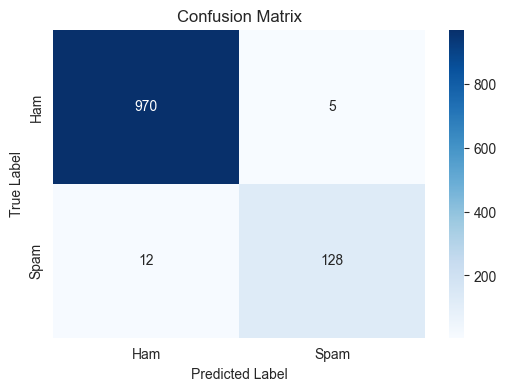

In [13]:
# Use the trained model to predict probabilities for the test data
y_pred_prob = model.predict(X_test)

# Convert predicted probabilities to binary class labels
# If the probability is greater than 0.5, classify as positive class (1, spam)
# Otherwise, classify as negative class (0, ham)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calculate the confusion matrix using true labels and predicted labels
conf_matrix = confusion_matrix(y_test, y_pred)


# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])
plt.yticks(ticks=[0.5, 1.5], labels=['Ham', 'Spam'])
plt.show()

##### True Negatives (970): The model correctly identified 970 messages as ham (not spam).
##### True Positives (128): The model correctly identified 128 messages as spam.
##### False Positives (5) and False Negatives (12): The model incorrectly classified 5 ham messages as spam and 12 spam messages as ham.

## Visualizing Training and Validation Performance

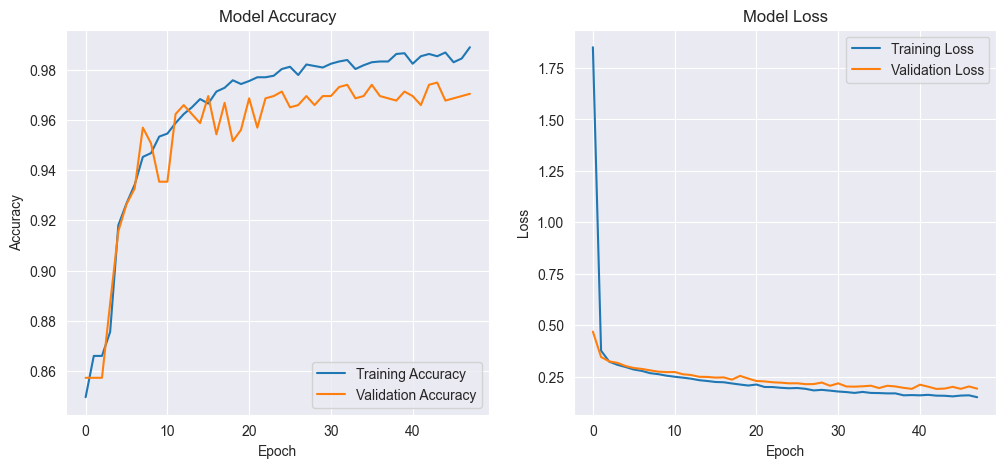

In [16]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_learning_curves(history)

##### The plots show the model’s accuracy increasing to 98% for training and 96% for validation, indicating strong learning and good generalization. The training and validation loss curves align closely, suggesting minimal overfitting and stable convergence. Overall, the model effectively balances learning on training and unseen data.

## Predict Spam or Ham from User Input
##### In this section, you can input custom SMS messages and see whether they are classified as spam or ham by the trained model. Run the cell below to test the model.

In [14]:
def predict_spam_or_ham(input_text):
    # Preprocess the input text
    cleaned_text = process_text(input_text)
    # Transform the text to a TF-IDF vector
    input_vector = vectorizer.transform([cleaned_text])
    # Predict the probability of spam
    predicted_prob = model.predict(input_vector)
    # Determine class based on threshold (0 = Ham, 1 = Spam)
    predicted_class = (predicted_prob > 0.5).astype("int32")[0][0]
    return "Spam" if predicted_class == 1 else "Ham"

# Get user input
user_input = input("Enter an SMS message to classify: ")

# Predict and print the result
result = predict_spam_or_ham(user_input)
print(f"The message is classified as: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
The message is classified as: Ham
